## Bra and Ket Definitions

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Naive Approach for Parent Hamiltonian

The main idea of the parent Hamiltonian is the following:

Given an ansatz represented by its state: $\ket{\Psi (\vec{\theta})}$ the parent Hamiltonian problem looks for a Hamiltonian $\mathcal{H}$ for the proposed ansatz which fundamental state and correspondent energy is 0. This is:

$$\mathcal{H}\ket{\Psi (\vec{\theta})} = 0 \tag{1}$$

The naive approach to this problem is the following:

1. Compute the density matrix of the ansatz:

$$\rho(\vec{\theta}) = \ket{\Psi (\vec{\theta})}\bra{\Psi (\vec{\theta})}$$

2. Compute the **Kernel** or **null space** of the density matrix. This:

$$\text{Kernel}(\rho) = \{ \ket{v^i} / \rho \ket{v^i} = 0, i=0, 1, \cdots m \, \text{with} \; m \leq dim(\rho)\}$$

3. Additionally the vectors of the kernel will be chosen that conforms a basis of this null space. 

$$\braket{v^i}{v^j}= \delta_{ij}$$

4. The vectors belonging to the **Kernel** of $\rho$ will satisfy following condition:

$$\rho \ket{v^i} = 0 = \ket{\Psi}\braket{\Psi}{v^i} = 0 \rightarrow \braket{\Psi}{v^i} = 0  \tag{2}$$

5. Now using the vector of the basis of the **Kernel** of $\rho$ we can compute the correspondent projectors $h^i$:

$$h^i = \ket{v^i}\bra{v^i}$$

6. By the condition (2) we can write:

$$h^i \ket{\Psi} = \ket{v^i} \braket{v^i}{\Psi} = 0 \tag{3}$$

7. We can join all the projectors terms for computing or desired parent hamiltonian:

$$\mathcal{H} = \sum_{i=0}^{m} h^i$$

By construction this Hamiltonian verify the parent Hamiltonian property (1)

In [ ]:
#Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy import linalg
import time

In [ ]:
%matplotlib inline

In [ ]:
# Original Parent Hamiltonian Library
import parent_hamiltonian.japanese.parent_hamiltonian as jap_parent

In [ ]:
# QLM ansatz
import parent_hamiltonian.ansatz.ansatz_qlm as ansatz_qlm
#QLM Libraries
from qat.core import Observable, Term
#QLM QPUs
from qat.qpus import PyLinalg, CLinalg
qpu = PyLinalg()

In [ ]:
np.random.seed(seed = 1)
depth = 3
angle_list = np.random.rand(depth*2)*2*np.pi
print("Answer_angle_list: ", angle_list)

## 1. Creating MPS of Ansatz

MPS version of the state of the ansatz

In [ ]:
nqubit = 3

In [ ]:
ansatz_mps, index_  = jap_parent.nqubit_mps(nqubit, angle_list)

In [ ]:
ansatz_mps.shape

## 2. QLM program

QLM implementation of the original ansatz

In [ ]:
qprog = ansatz_qlm.ansatz_qlm(nqubits=nqubit, depth=depth)
circuit = qprog.to_circ()

In [ ]:
%qatdisplay circuit --svg

## 3. Computing Parent Hamiltonian Terms

We have developed a package for computing  the naive approach to the parent Hamiltonian problem. Here we compare the performance of the naive approach vs the original paper (Japanese Package from now)

In [ ]:
# Thios is a threshold for evaluate the coefficients of the different terms
# of the hamiltoninans
threshold = 1.0e-4

### 3.1 Parent Hamiltonian: Japanese Package

The *parent_hamiltonian* function from **parent_hamiltonian/japanese/parent_hamiltonian** package computes the parent hamiltonian for the ansatz original parent hamiltonian paper (using the original code stored in the GitHub of the paper)

In [ ]:
%%time
pauliproducts_factor_list, rho_jap, kernel_jap = jap_parent.parent_hamiltonian(
    ansatz_mps, index_, nqubit)

In [ ]:
pauliproducts_factor_list

In [ ]:
np.linalg.matrix_rank(rho_jap)

In [ ]:
for i in range(1,len(pauliproducts_factor_list), 3):
    print(pauliproducts_factor_list[i])

#### Observable from Japanese Hamiltonian

Now we can transform the parent hamiltonian terms for proper format for QLM

In [ ]:
#We need to change Hamiltonian between ParentHamiltonian and QLM Observables
list_of_terms = []
coefs_jap = []
for pauli in pauliproducts_factor_list:
    step = pauli[1]
    #first we pick the letters
    a=re.findall(r'[A-Z]', step)
    #second we pick the number
    b = re.findall(r'\d+', step)
    #We create the QLM Term object: Term(coefficient, gates, qbits where gates are applied)
    list_of_terms.append(
        Term(pauli[0], ''.join(a), [int(i) for i in b])
    )
    coefs_jap.append(pauli[0])
#With the list of QLM Terms we create the QLM Observable object
obs = Observable(nqubit, pauli_terms=list_of_terms)
coefs_jap = np.array(coefs_jap)

In [ ]:
plt.hist(coefs_jap)

In [ ]:
# Here we compute the percentage of coefficients lower than threshold
jap_thresh_coefs = sum(np.abs(coefs_jap) < threshold)
jap_number_coefs = len(coefs_jap)
100 * jap_thresh_coefs / jap_number_coefs

#### Evaluation of Japanese Hamiltonian in QLM

In [ ]:
#QLM job from circuit. In Observable Mode!!
job = circuit.to_job('OBS', observable=obs)
#We are going to fix the parameters of the PQC to the ideal ones!!
job_eval = job(** {v: angle_list[i] for i,v in enumerate(job.get_variables())})
#We submit the job to the QPU
r_eval = qpu.submit(job_eval)
# This is the Energy. This should be near zero
r_eval.value

### 3.2 Parent Hamiltonian naive approach

The naive approach presented at the begining of the notebook is implemented in the package *parent_hamiltonian* of the **parent_hamiltonian/naive** module of the library. 

The *parent_hamiltonian* function from **parent_hamiltonian/naive/parent_hamiltonian** package allow to build the parent hamiltonian

In [ ]:
from parent_hamiltonian.naive import parent_hamiltonian as naive

In [ ]:
%%time
coefs, pauli_s, rho_naive, kernel_naive, projector_naive = naive.parent_hamiltonian(
    ansatz_mps)

$\text{ansatz_mps} = \ket{\Psi(\vec{\theta})}$

In [ ]:
coefs_naive = np.array(coefs)
naive_thresh_coefs = sum(np.abs(coefs_naive) < threshold)
naive_number_coefs = len(coefs_naive)

In [ ]:
coefs_naive

In [ ]:
plt.hist(coefs_naive, bins = 100)

In [ ]:
naive_thresh_coefs / naive_number_coefs

#### Observable from Hamiltonian of Complete Density Matrix

In [ ]:
Terms = [Term(coef, pauli, [i for i in range(len(pauli))]) \
         for coef, pauli in zip(coefs, pauli_s)]

#### Evaluation from Complete Density Matrix Hamiltoninan in QLM

In [ ]:
obs_rho = Observable(nqubit, pauli_terms = Terms)
#QLM job from circuit. In Observable Mode!!
job_rho = circuit.to_job('OBS', observable=obs_rho)
#We are going to fix the parameters of the PQC to the ideal ones!!
job_rho_2 = job_rho(** {v: angle_list[i] for i,v in enumerate(job_rho.get_variables())})
#We submit the job to the QPU
r_rho = qpu.submit(job_rho_2)
# This is the Energy. This should be near zero
r_rho.value

In [ ]:
%qatdisplay circuit --svg

## 4. Japanese Benchmark

Now we are going to execute a benchmark for evaluate performance for an increasing number of qubits using the original japanese code

In [ ]:
jap_results = []
jap_coefs = {}
for nqubit in list(range(3, 12)):
    ansatz_mps, index_  = jap_parent.nqubit_mps(nqubit, angle_list)
    tick = time.time()
    pauliproducts_factor_list, _, _= jap_parent.parent_hamiltonian(ansatz_mps, index_, nqubit)
    tock = time.time()
    coefs_jap = np.array([pauli[0] for pauli in pauliproducts_factor_list])
    elapsed = tock - tick
    jap_thresh_coefs = sum(np.abs(coefs_jap) < threshold)
    jap_number_coefs = len(coefs_jap)
    percentaje = 100 * jap_thresh_coefs/jap_number_coefs
    jap_results.append(
        [nqubit, elapsed, jap_thresh_coefs, jap_number_coefs, percentaje]
    )
    jap_coefs.update({nqubit:coefs_jap})

## 5. Naive Benchmark

Now we are going to execute same benchmark for the naive approach

In [ ]:
naive_results = []
naive_coefs = {}
for nqubit in list(range(3, 10)):
    print('nqubit: {}'.format(nqubit))
    ansatz_mps, index_ = jap_parent.nqubit_mps(nqubit, angle_list)
    tick = time.time()
    coefs, pauli_s, _, _, _ = naive.parent_hamiltonian(ansatz_mps)
    tock = time.time()
    elapsed = tock - tick
    coefs_naive = np.array(coefs)
    naive_thresh_coefs = sum(np.abs(coefs_naive) < threshold)
    naive_number_coefs = len(coefs_naive)
    percentaje = 100 * naive_thresh_coefs/naive_number_coefs
    naive_results.append(
        [nqubit, elapsed, naive_thresh_coefs, naive_number_coefs, percentaje]
    )
    naive_coefs.update({nqubit:coefs_naive})

In [ ]:
jap_df = pd.DataFrame(
    jap_results, 
    columns=['nqubit', 'run_time', 'threshold_coefs','number_coefs', 'percent_thresh']
)

naive_df = pd.DataFrame(
    naive_results, 
    columns=['nqubit', 'run_time', 'threshold_coefs','number_coefs', 'percent_thresh']
)

In [ ]:
naive_df

In [ ]:
4 ** 9

In [ ]:
plt.plot(jap_df['nqubit'], jap_df['run_time'], 'o-')
plt.plot(naive_df['nqubit'], naive_df['run_time'], 'o-')
plt.yscale('log')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend(['Japanese', 'Naive'])

In [ ]:
plt.plot(jap_df['nqubit'], jap_df['percent_thresh'], 'o-')
plt.plot(naive_df['nqubit'], naive_df['percent_thresh'], 'o-')
plt.xlabel('Number of Qubits')
plt.ylabel('Percent Threshold')
plt.legend(['Japanese', 'Naive'])
plt.title('Percent of coeficients lower than {}'.format(threshold))

In [ ]:
more_thresh_jap = []
for n_, coef_ in jap_coefs.items():
    more_thresh_jap.append(sum((np.abs(coef_) < 1e-6)))
more_thresh_jap = np.array(more_thresh_jap)

In [ ]:
more_thresh_naive = []
for n_, coef_ in naive_coefs.items():
    more_thresh_naive.append(sum((np.abs(coef_) < 1e-6)))
more_thresh_naive = np.array(more_thresh_naive)

In [ ]:
more_thresh_naive

In [ ]:
plt.plot(jap_df['nqubit'], more_thresh_jap / jap_df['number_coefs'], 'o-')
plt.plot(naive_df['nqubit'], more_thresh_naive / naive_df['number_coefs'] , 'o-')
#plt.yscale('log')
plt.xlabel('Number of Qubits')
plt.ylabel('Percent Threshold')
plt.legend(['Japanese', 'Naive'])
plt.title('Percent of coeficients lower than {}'.format(1e-6))

### Performance comparison of methods

Here we compare the runtime for computation of Hamiltonian terms for both methods.

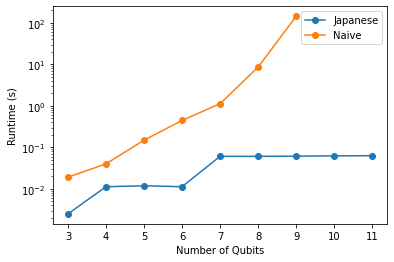

Here we have used parallel computation for getting the hamiltoninan terms for the naive approach meanwhile the computation in the japanese package only one core was used. **So even taking advantage of multicore proccessing the naive method has a very bad performance** 

This is because for the final projector matrix it is needed to compute its pauli decomposition. In the naive approach this matrix will be (nqubit, nqubit) shape matrix. So we will need a basis of kronecker pauli products of $4^{nqubit}$ elements.

#### Percentage of Coeficients lower than Threshold

Here we plot the number of coefficients of Hamiltoninan terms with coefficients lower than $10^{-4}$.

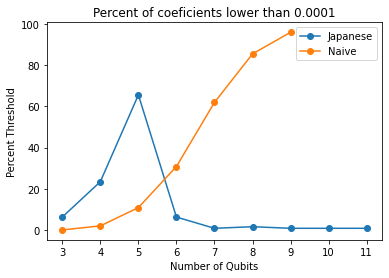


Here we plot the number of coefficients of Hamiltoninan terms with coefficients lower than $10^{-6}$. 

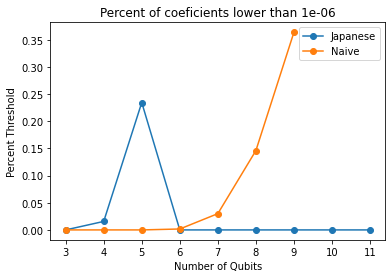

So in general use this naive approach will have a very bad performance. The idea of the original parent hamiltonian is to create **local parent hamiltonians** so instead of having a complete Haimltonian that affects to all the qbuits of the ansatz they will have several lower dimension hamiltoninans that only will affect to groups of qubits of the ansatz. This idea allows to increase the performance of the parent hamiltonian computations.